# Part 2 : Convolutional Neural Networks

In [1]:
from __future__ import print_function

import os
import random
import numpy as np
import tensorflow as tf
from six.moves import range
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt


#configuration for gpu usage
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.4
conf.gpu_options.allow_growth = True
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
from tensorflow.python.keras.datasets.cifar10 import load_data
(train_dataset, train_labels), (test_dataset, test_labels) = load_data()
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()
print('Dataset ready')

Dataset ready


==== Show CIFAR10 images ====


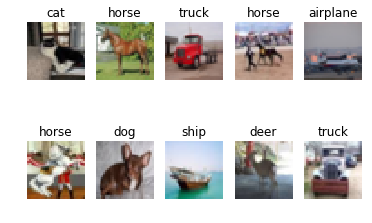

In [3]:
Row = 2
Column = 5
ListOfLabel = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("==== Show CIFAR10 images ====")

rand = random.randint(0, 49989)
images = train_dataset[rand:rand+10]
labels = train_labels[rand:rand+10].squeeze()
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('{}'.format(ListOfLabel[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
image_size = 32
num_labels = 10

train_X = train_dataset.reshape(-1, image_size, image_size, 3)
test_X = test_dataset.reshape(-1, image_size, image_size, 3)
train_y = (np.arange(10) == train_labels[:,None])
test_y = (np.arange(10) == test_labels[:,None])
print(train_X.shape, test_X.shape)
print(train_y.shape, test_y.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)


In [5]:
training_iters = 20
learning_rate = 0.001 
batch_size = 128

n_input = image_size

n_classes = 10

In [6]:
x = tf.placeholder("float", [None, image_size, image_size, 3])
y = tf.placeholder("float", [None, n_classes])

In [7]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [8]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,3,32), initializer=tf.contrib.layers.xavier_initializer()), 
    #'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    #'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W1', shape=(16*16*32,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W2', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    #'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    #'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B1', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B2', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
def conv_net(x, weights, biases):  

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1, k=2)

    #conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    #conv2 = tf.nn.relu(conv2)
    #conv2 = maxpool2d(conv2, k=2)

    #conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    #conv3 = tf.nn.relu(conv3)
    #conv3 = maxpool2d(conv3, k=2)

    fc1 = tf.reshape(conv1, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [10]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [11]:
init = tf.global_variables_initializer()

In [12]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            opt = sess.run(optimizer, feed_dict={x:batch_x, y:batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y:batch_y})

        print("Iter " + str(i) + ", Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))

        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 1.786590, Training Accuracy= 0.42969
Testing Accuracy: 0.34220
Iter 1, Loss= 1.448282, Training Accuracy= 0.50000
Testing Accuracy: 0.41710
Iter 2, Loss= 1.304770, Training Accuracy= 0.54688
Testing Accuracy: 0.46100
Iter 3, Loss= 1.183462, Training Accuracy= 0.53906
Testing Accuracy: 0.48400
Iter 4, Loss= 1.101637, Training Accuracy= 0.57031
Testing Accuracy: 0.49710
Iter 5, Loss= 1.000717, Training Accuracy= 0.62500
Testing Accuracy: 0.50580
Iter 6, Loss= 0.914474, Training Accuracy= 0.67969
Testing Accuracy: 0.50870
Iter 7, Loss= 0.871093, Training Accuracy= 0.65625
Testing Accuracy: 0.50920
Iter 8, Loss= 0.769069, Training Accuracy= 0.71094
Testing Accuracy: 0.51480
Iter 9, Loss= 0.724488, Training Accuracy= 0.73438
Testing Accuracy: 0.50950
Iter 10, Loss= 0.659360, Training Accuracy= 0.77344
Testing Accuracy: 0.50310
Iter 11, Loss= 0.592727, Training Accuracy= 0.76562
Testing Accuracy: 0.50130
Iter 12, Loss= 0.555275, Training Accuracy= 0.82812
Testing Accuracy: 0.50

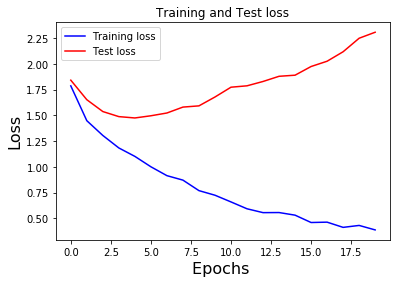

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

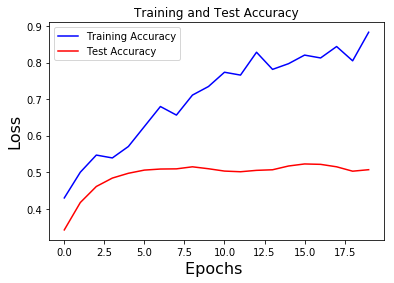

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()